In [3]:
import numpy as np
import torch
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
import pandas as pd
import anndata
import networkx as nx
import scvelo as scv

from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from RnaVeloDataset import RnaVeloDataset

import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from torch_geometric.data import DataLoader
from torch_geometric.nn import GINConv, GCNConv, SAGEConv, GATConv
from torch_geometric.utils import train_test_split_edges
from RnaVeloDataset import RnaVeloDataset
import numpy as np
import matplotlib.pyplot as plt
from model.BaseModel import BaseModel
from sklearn.metrics import mean_squared_error
from math import sqrt

In [4]:
backbones = ["linear_simple"]
seed = [2]
trans_rate = [1, 5, 10]
split_rate = [0.1, 0.5, 1, 5, 10]
num_cells = [210, 220, 230, 240, 250, 260, 270, 280, 290, 300]
root = 'data/'

combined = [(bb, sd, tr, sr, nc) for bb in backbones for sd in seed for tr in trans_rate for sr in split_rate for nc in num_cells]
data_list = []
adata_list = []

for item in combined:
    bb, sd, tr, sr, nc = item
    path = root + bb + "_" + str(sd) + "_" + str(tr) + "_" + str(sr) + "_" + str(nc)
    df = pd.read_csv(path + "_unspliced.csv")
    df = df.drop(df.columns[[0]], axis=1)
    X_unspliced = df.to_numpy()

    df = pd.read_csv(path + "_spliced.csv")
    df = df.drop(df.columns[[0]], axis=1)
    X_spliced = df.to_numpy()

    df = pd.read_csv(path + "_cell_info.csv")
    df = df.drop(df.columns[[0]], axis=1)
    X_obs = df

    adata = anndata.AnnData(X = csr_matrix(X_spliced),
                    obs = X_obs,
                    layers = dict(
                        unspliced = csr_matrix(X_unspliced),
                        spliced = csr_matrix(X_spliced)
                    ))

    adata_list.append(adata)
    continue

    # compute velocity
    scv.tl.velocity_graph(adata)

    # dimension reduction
    X_concat = np.concatenate((X_spliced,X_unspliced),axis=1)
    pca = PCA(n_components=30, svd_solver='arpack')
    pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=30, svd_solver='arpack'))])
    features_pca = pipeline.fit_transform(X_concat)

    # predict gene expression data
    velo_matrix = adata.layers["velocity"].copy()
    X_pre = X_spliced + velo_matrix/np.linalg.norm(velo_matrix,axis=1)[:,None]*3

    X_pca_ori = pca.fit_transform(X_spliced)
    X_pca_pre = pca.transform(X_pre)
    velo_pca = X_pca_pre - X_pca_ori

    directed_conn = kneighbors_graph(X_pca_ori, n_neighbors=35, mode='connectivity', include_self=False).toarray()
    conn = directed_conn + directed_conn.T
    conn[conn.nonzero()[0],conn.nonzero()[1]] = 1

    x = torch.from_numpy(X_pca_ori.copy())
    edge_index = np.array(np.where(conn == 1))
    
    y = X_obs['sim_time'].to_numpy().reshape((-1, 1))
    scaler = MinMaxScaler((0, 200))
    scaler.fit(y)
    y = torch.FloatTensor(scaler.transform(y).reshape(-1))

    edge_attr = np.array([])
    for i in range(conn.shape[0]):
        indices = conn[i,:].nonzero()[0]
        diff = X_pca_ori[indices,:] - X_pca_ori[i,:]
        distance = np.linalg.norm(diff, axis=1, ord=2)[:,None]
        penalty = np.matmul(diff, velo_pca[i,:, None])/\
        (np.linalg.norm(velo_pca[i,:], ord=2) * distance)
        penalty = np.nan_to_num(penalty, 0)
        weights = (np.exp(penalty)/np.sum(np.exp(penalty))).squeeze()
        edge_attr = np.append(edge_attr, weights)
    edge_attr = torch.LongTensor(edge_attr)
    
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    print(edge_index.shape)
    data_list.append(data)

Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.
T

## One graph

In [5]:
dataset = RnaVeloDataset(root='data/')
data = dataset[2]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BaseModel(dataset.num_features).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

def train(data):
    model.train()
    optimizer.zero_grad()

    data = data.to(device)
    output = model(data)
    label = data.y.to(device)
    loss = F.mse_loss(output, label)
    loss.backward()
    optimizer.step()

    return float(loss)

def test(data):
    model.eval()
    
    correct = []
    predict = []
    data = data.to(device)
    label = data.y.detach().cpu().numpy().reshape(-1)
    pred = model(data).detach().cpu().numpy().reshape(-1)
    # print(pred.shape)
    correct.extend(label)
    predict.extend(pred)
    correct = np.array(correct)
    predict = np.array(predict)
    return mean_squared_error(correct, predict)

train_list = []
val_list = []

best_val_perf = test_perf = 0
for epoch in range(251):
    train_loss = train(data)
    train_acc = test(data)
    val_acc = test(data)
    test_acc = test(data)
    log = 'Epoch: {:03d}, Loss: {:.4f}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, train_acc, val_acc, test_acc))

    train_list.append(train_acc)
    val_list.append(val_acc)

Epoch: 000, Loss: 0.3649, Train: 0.3579, Val: 0.3579, Test: 0.3579
Epoch: 010, Loss: 0.3003, Train: 0.2942, Val: 0.2942, Test: 0.2942
Epoch: 020, Loss: 0.2402, Train: 0.2340, Val: 0.2340, Test: 0.2340
Epoch: 030, Loss: 0.1746, Train: 0.1676, Val: 0.1676, Test: 0.1676
Epoch: 040, Loss: 0.1071, Train: 0.1008, Val: 0.1008, Test: 0.1008
Epoch: 050, Loss: 0.0542, Train: 0.0506, Val: 0.0506, Test: 0.0506
Epoch: 060, Loss: 0.0307, Train: 0.0293, Val: 0.0293, Test: 0.0293
Epoch: 070, Loss: 0.0162, Train: 0.0149, Val: 0.0149, Test: 0.0149
Epoch: 080, Loss: 0.0077, Train: 0.0073, Val: 0.0073, Test: 0.0073
Epoch: 090, Loss: 0.0047, Train: 0.0046, Val: 0.0046, Test: 0.0046
Epoch: 100, Loss: 0.0038, Train: 0.0037, Val: 0.0037, Test: 0.0037
Epoch: 110, Loss: 0.0031, Train: 0.0031, Val: 0.0031, Test: 0.0031
Epoch: 120, Loss: 0.0026, Train: 0.0026, Val: 0.0026, Test: 0.0026
Epoch: 130, Loss: 0.0022, Train: 0.0022, Val: 0.0022, Test: 0.0022
Epoch: 140, Loss: 0.0019, Train: 0.0019, Val: 0.0019, Test: 0.

In [6]:
i = 2
model.eval()
adata = adata_list[i]
scv.tl.velocity_graph(adata)
adata.obs['pred_sim_time'] = model(data.to(device)).detach().cpu().numpy().reshape(-1)
scv.pl.scatter(adata, color=['pred_sim_time','sim_time'], color_map='gnuplot', legend_loc='on data')

computing neighbors
    finished(0:00:02)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


ValueError: Length of values does not match length of index

In [ ]:
plt.plot(train_list)
plt.show()

## Batch

In [29]:
dataset = RnaVeloDataset(root='data/')
len(dataset)

150

In [30]:
def train():
    model.train()

    total_loss = 0
    mse = nn.MSELoss()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y.to(device)
        loss = torch.sqrt(mse(output, label))
        loss.backward()
        total_loss += data.num_graphs * loss.item()
        optimizer.step()

    return float(total_loss / len(train_loader.dataset))

def test(loader):
    model.eval()
    
    correct = []
    predict = []
    for data in loader:
        data = data.to(device)
        label = data.y.detach().cpu().numpy().reshape(-1)
        pred = model(data).detach().cpu().numpy().reshape(-1)
        # print(pred.shape)
        correct.extend(label)
        predict.extend(pred)
    correct = np.array(correct)
    predict = np.array(predict)
    return sqrt(mean_squared_error(correct, predict))


In [37]:
dataset = RnaVeloDataset(root='data/')
batch_size = 5
train_loader = DataLoader(dataset[:120], batch_size=batch_size)
val_loader = DataLoader(dataset[120:135], batch_size=batch_size)
test_loader = DataLoader(dataset[135:160], batch_size=1)

data = dataset[0]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model = BaseModel(dataset.num_features).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4, weight_decay=0.01)

best_val_perf = test_perf = 0

train_list = []
val_list = []
for epoch in range(251):
    train_loss = train()
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    test_acc = test(test_loader)
    log = 'Epoch: {:03d}, Loss: {:.4f}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, train_acc, val_acc, test_acc))
    
    train_list.append(train_acc)
    val_list.append(val_acc)

Epoch: 000, Loss: 0.4525, Train: 0.4499, Val: 0.5091, Test: 0.5211
Epoch: 010, Loss: 0.3438, Train: 0.3424, Val: 0.3929, Test: 0.3975
Epoch: 020, Loss: 0.2694, Train: 0.2688, Val: 0.2849, Test: 0.3326
Epoch: 030, Loss: 0.2299, Train: 0.2428, Val: 0.2144, Test: 0.3643
Epoch: 040, Loss: 0.2063, Train: 0.2447, Val: 0.1820, Test: 0.4139
Epoch: 050, Loss: 0.2009, Train: 0.2494, Val: 0.1771, Test: 0.4319
Epoch: 060, Loss: 0.1994, Train: 0.2501, Val: 0.1762, Test: 0.4351
Epoch: 070, Loss: 0.1986, Train: 0.2503, Val: 0.1758, Test: 0.4363
Epoch: 080, Loss: 0.1981, Train: 0.2503, Val: 0.1756, Test: 0.4369
Epoch: 090, Loss: 0.1977, Train: 0.2504, Val: 0.1755, Test: 0.4373
Epoch: 100, Loss: 0.1975, Train: 0.2505, Val: 0.1754, Test: 0.4377
Epoch: 110, Loss: 0.1973, Train: 0.2505, Val: 0.1753, Test: 0.4379
Epoch: 120, Loss: 0.1972, Train: 0.2506, Val: 0.1752, Test: 0.4380
Epoch: 130, Loss: 0.1971, Train: 0.2506, Val: 0.1752, Test: 0.4381
Epoch: 140, Loss: 0.1970, Train: 0.2506, Val: 0.1751, Test: 0.

Batch(batch=[260], edge_index=[2, 1626], x=[260, 10], y=[260, 1])
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


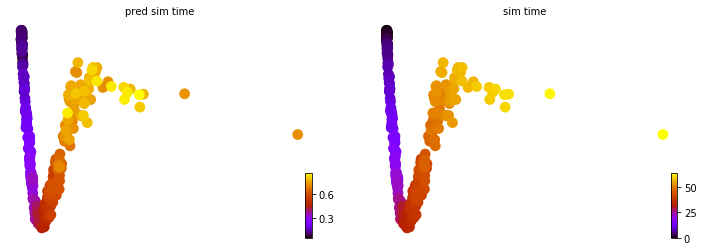

Batch(batch=[270], edge_index=[2, 1716], x=[270, 10], y=[270, 1])
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


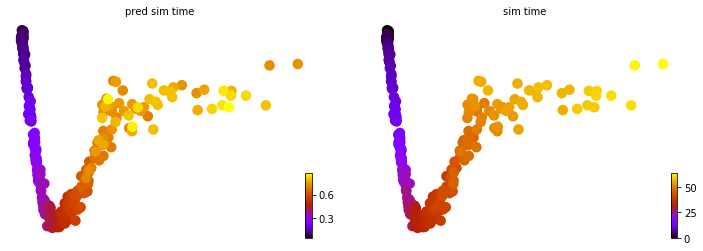

Batch(batch=[280], edge_index=[2, 1790], x=[280, 10], y=[280, 1])
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


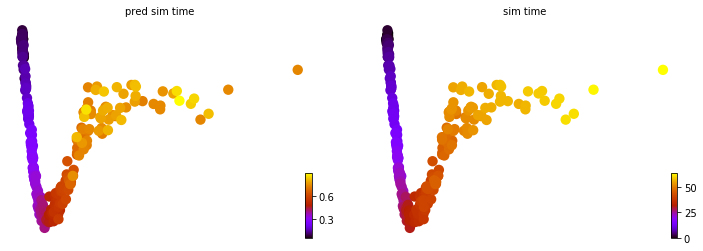

Batch(batch=[290], edge_index=[2, 1810], x=[290, 10], y=[290, 1])
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


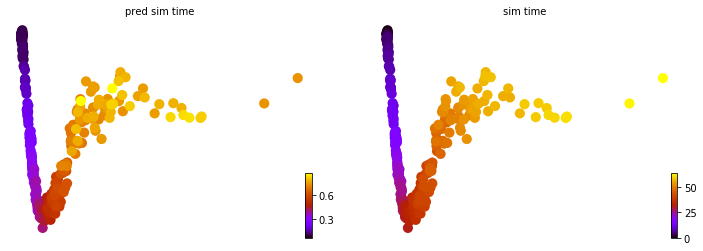

Batch(batch=[300], edge_index=[2, 1884], x=[300, 10], y=[300, 1])
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


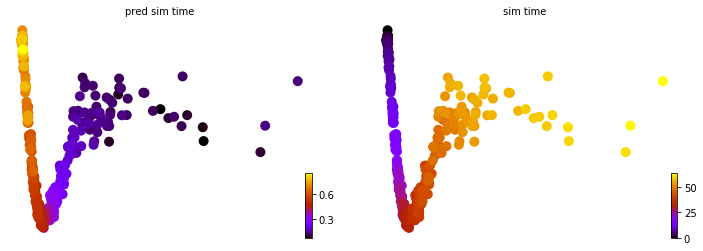

Batch(batch=[210], edge_index=[2, 1306], x=[210, 10], y=[210, 1])
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


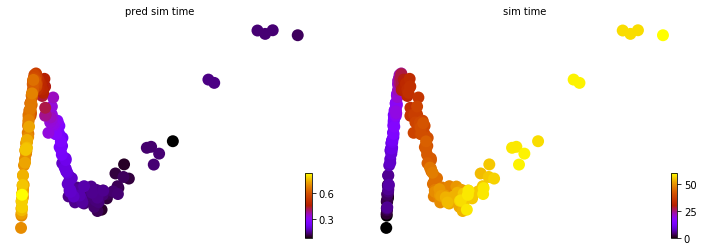

Batch(batch=[220], edge_index=[2, 1402], x=[220, 10], y=[220, 1])
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


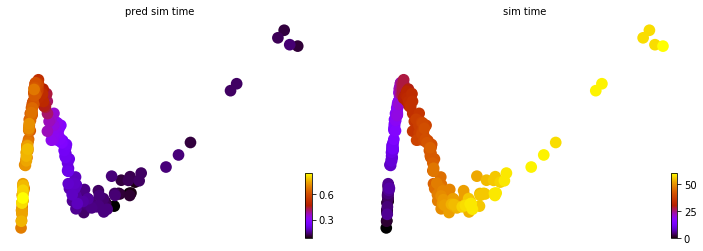

Batch(batch=[230], edge_index=[2, 1442], x=[230, 10], y=[230, 1])
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


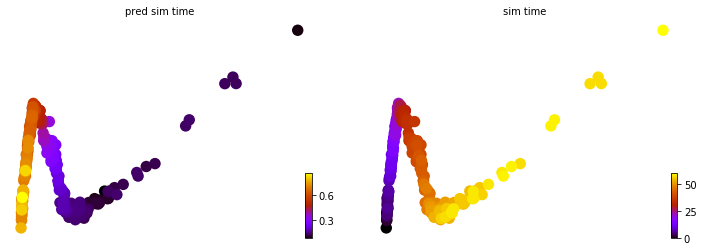

Batch(batch=[240], edge_index=[2, 1470], x=[240, 10], y=[240, 1])
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


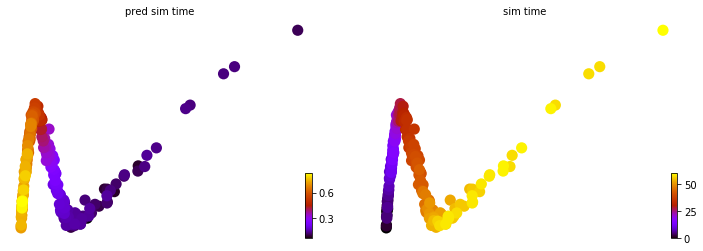

Batch(batch=[250], edge_index=[2, 1570], x=[250, 10], y=[250, 1])
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


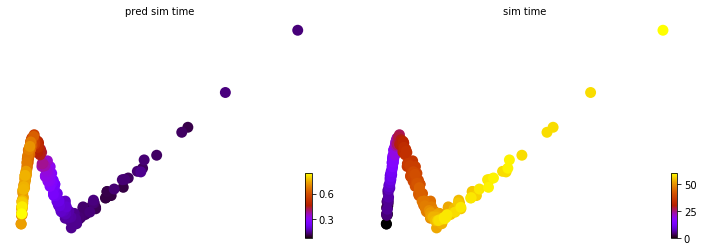

Batch(batch=[260], edge_index=[2, 1590], x=[260, 10], y=[260, 1])
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


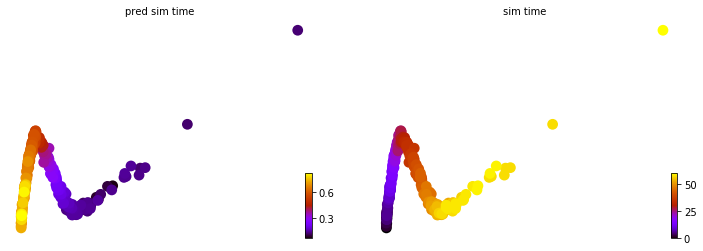

Batch(batch=[270], edge_index=[2, 1688], x=[270, 10], y=[270, 1])
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


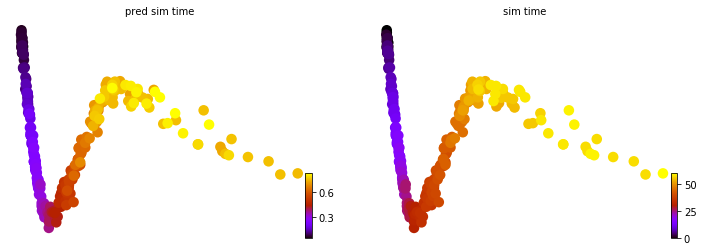

Batch(batch=[280], edge_index=[2, 1736], x=[280, 10], y=[280, 1])
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


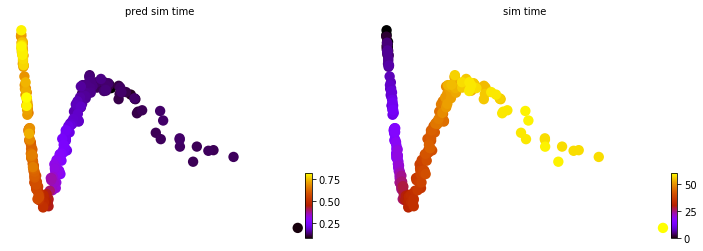

Batch(batch=[290], edge_index=[2, 1814], x=[290, 10], y=[290, 1])
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


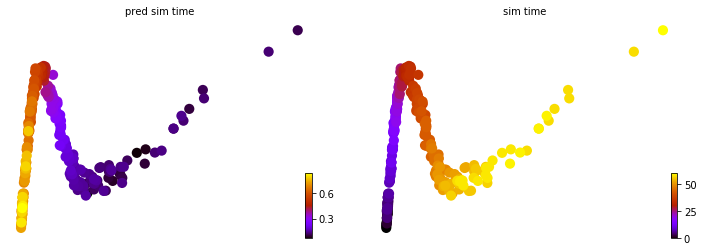

Batch(batch=[300], edge_index=[2, 1864], x=[300, 10], y=[300, 1])
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


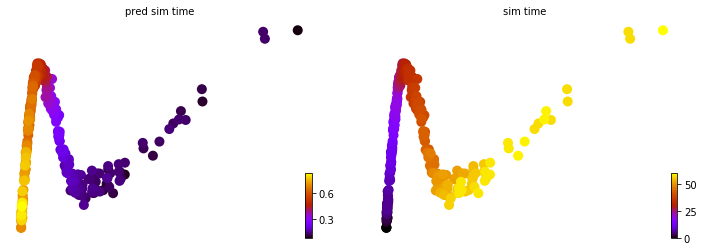

In [38]:
i = 135
model.eval()
for data in test_loader:
    print(data)
    adata = adata_list[i]
    scv.tl.velocity_graph(adata)
    adata.obs['pred_sim_time'] = model(data.to(device)).detach().cpu().numpy().reshape(-1)
    i += 1
    scv.pl.scatter(adata, color=['pred_sim_time','sim_time'], color_map='gnuplot', legend_loc='on data')

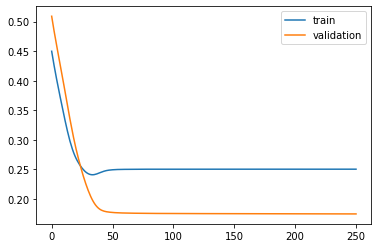

In [39]:
plt.plot(train_list)
plt.plot(val_list)
plt.legend(['train', 'validation'], loc='uppder right')
plt.show()

In [48]:
train_loader.batch_size * len(train_loader)

120

In [9]:
print(adata)

AnnData object with n_obs × n_vars = 230 × 150 
    obs: 'cell_id', 'step_ix', 'simulation_i', 'sim_time', 'num_molecules', 'mult', 'lib_size', 'n_counts', 'velocity_self_transition'
    var: 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_settings', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'unspliced', 'spliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
